---

**Сначала загрузите веса модели(файл best_nmr_param_cnn.pth) в локальное хранилище!**

---

Устройство: cpu
Загружена лучшая CNN-модель (best_nmr_param_cnn.pth) для тестирования.

Начало анализа: генерация примеров с 1, 2, 3 и 4 компонентами


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(


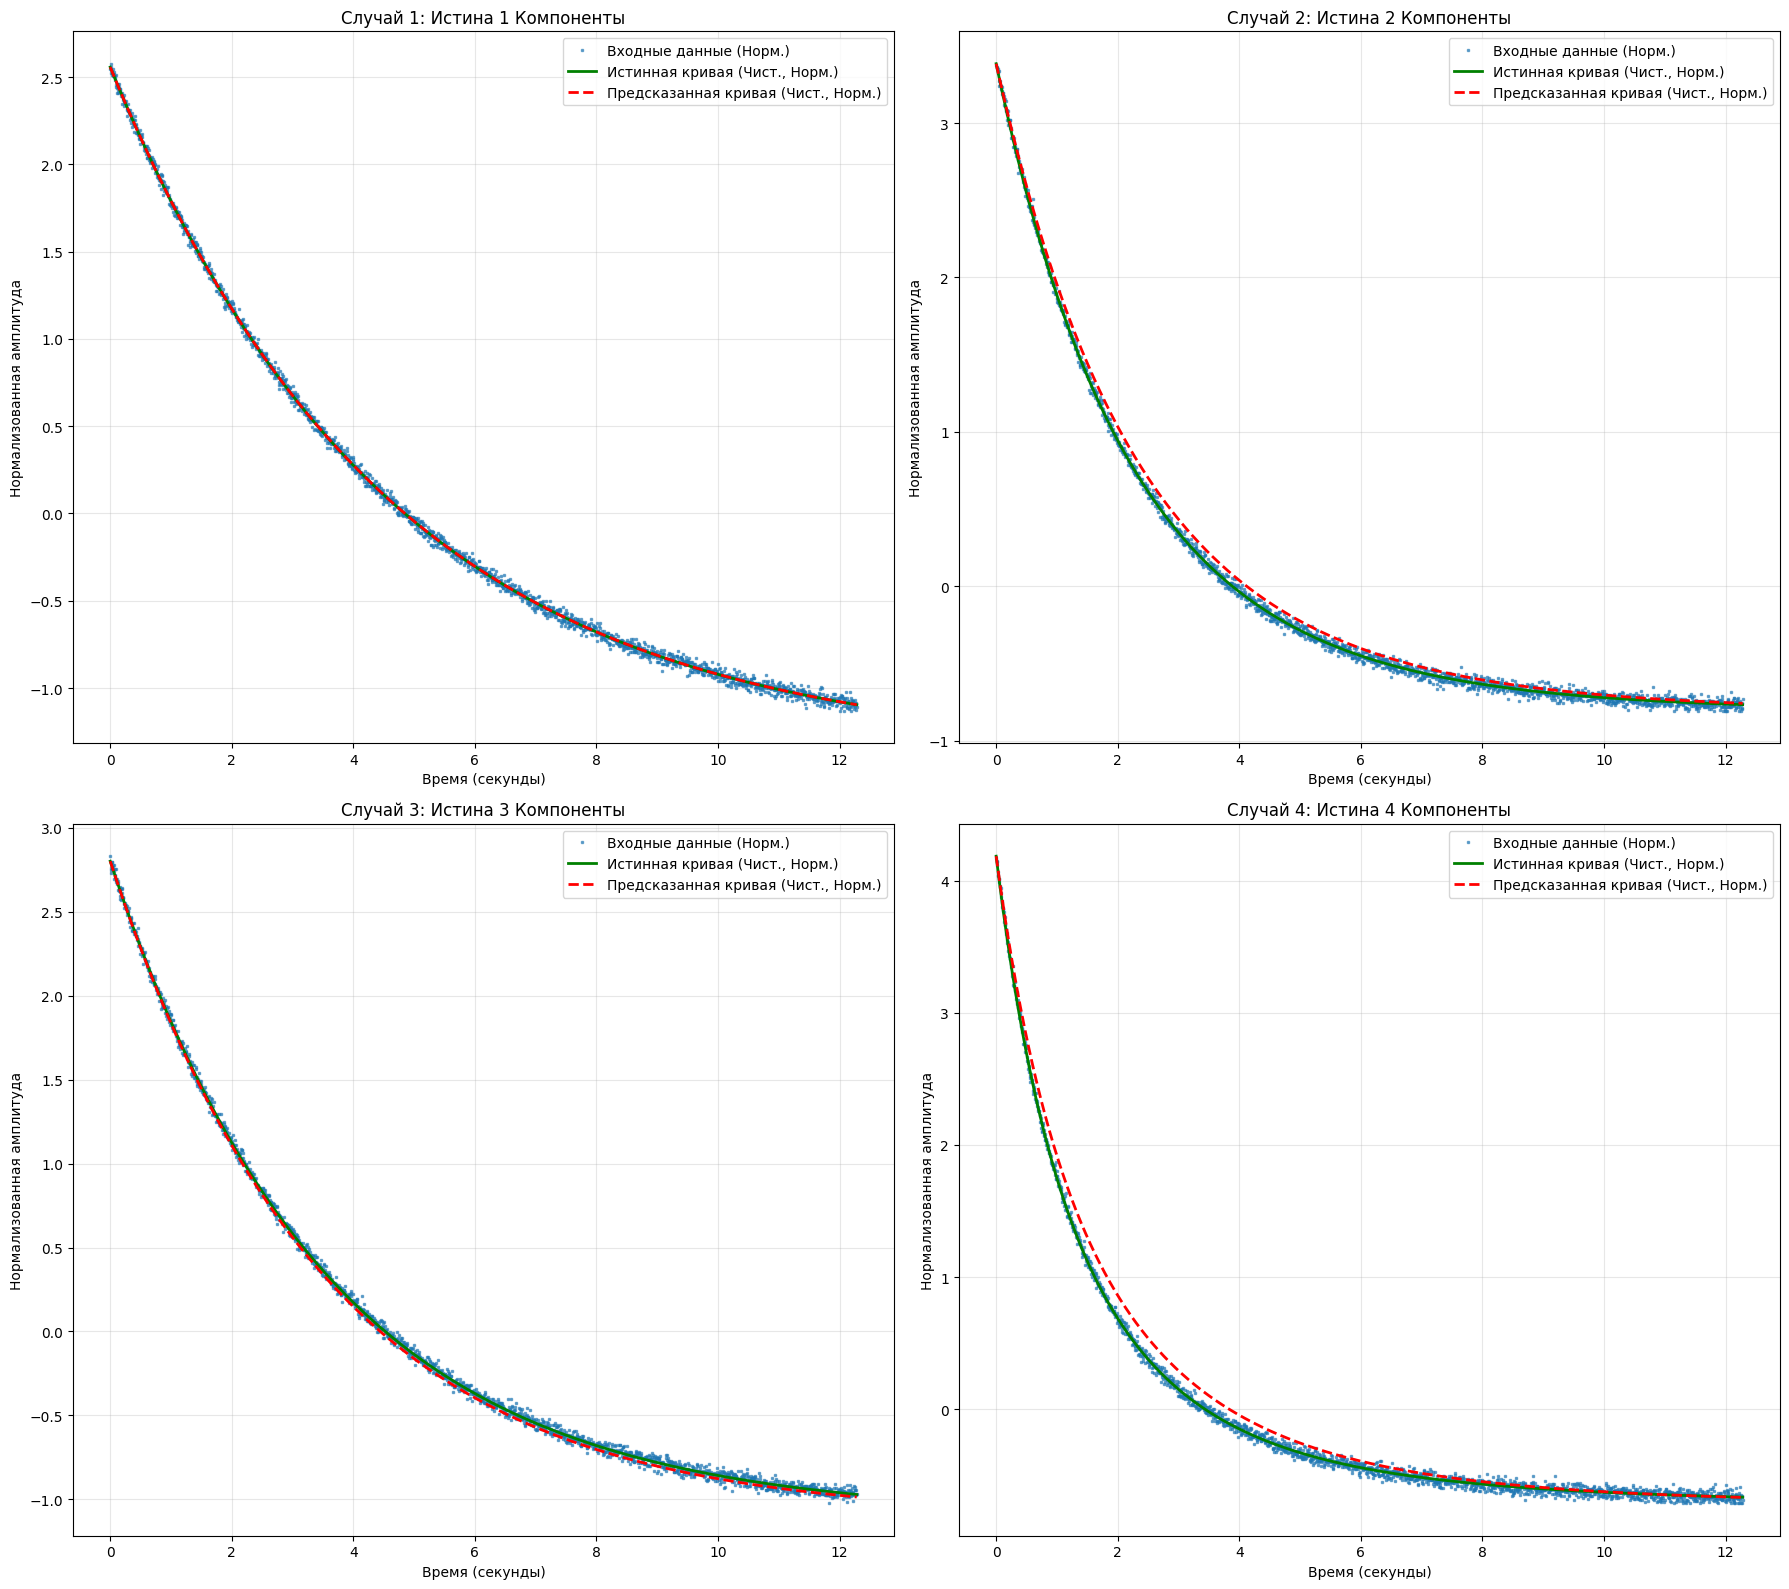


Таблица с истинными и предсказанными параметрами

Случай 1 (1 компонента):


,T2 Истина,T2 Пред.,W Истина,W Пред.
Компонента,,,,
**Компонента 1 (Ист.)**,4.5936,4.5961,1.000,1.000
Компонента 2,-,4.7617,-,0.000
Компонента 3,-,4.8947,-,0.000
Компонента 4,-,4.9031,-,0.000



Случай 2 (2 компонента):


,T2 Истина,T2 Пред.,W Истина,W Пред.
Компонента,,,,
**Компонента 1 (Ист.)**,1.8444,1.8990,0.595,0.499
**Компонента 2 (Ист.)**,3.1968,2.8635,0.405,0.271
Компонента 3,-,3.4087,-,0.179
Компонента 4,-,3.8933,-,0.052



Случай 3 (3 компонента):


,T2 Истина,T2 Пред.,W Истина,W Пред.
Компонента,,,,
**Компонента 1 (Ист.)**,3.1904,3.5172,0.393,0.997
**Компонента 2 (Ист.)**,3.6593,3.7409,0.481,0.003
**Компонента 3 (Ист.)**,4.6734,3.9983,0.126,0.000
Компонента 4,-,4.2222,-,0.000



Случай 4 (4 компонента):


,T2 Истина,T2 Пред.,W Истина,W Пред.
Компонента,,,,
**Компонента 1 (Ист.)**,0.6605,0.6652,0.227,0.187
**Компонента 2 (Ист.)**,1.2870,1.4187,0.238,0.370
**Компонента 3 (Ист.)**,1.8208,2.3815,0.381,0.257
**Компонента 4 (Ист.)**,4.3368,3.8388,0.154,0.187


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# 1. КОНСТАНТЫ

# Параметры данных
N_POINTS = 2048   # Длина входного сигнала КПМГ
T_MAX = 12.282    # Максимальное время сигнала КПМГ
NOISE_STD = 0.006

# Диапазон T2
T2_MIN = 0.1
T2_MAX = 5.0

# Массив времени
T_ECHOES = torch.linspace(0, T_MAX, N_POINTS)
CHECKPOINT_PATH = "best_nmr_param_cnn.pth"


# 2. КЛАСС ДАТАСЕТА(генерация паралельно обучению. Без этого есть проблема нехватки ОЗУ)
class NMROnTheFlyDataset(Dataset):
    def __init__(self, num_samples: int):
        self.num_samples = num_samples
        self.W_MIN = 0.1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        rng = torch.Generator()
        rng.manual_seed(idx % (2**32))

        # Генерация 1-4 компонент
        probs = torch.tensor([0.25, 0.25, 0.25, 0.25])
        n_comp = torch.multinomial(probs, 1, generator=rng).item() + 1

        # Генерация T2
        u = torch.rand(n_comp, generator=rng)
        T2 = u * (T2_MAX - T2_MIN) + T2_MIN
        T2, _ = torch.sort(T2)

        # Генерация весов (w)
        W_RANGE = 1.0 - self.W_MIN
        w = torch.rand(n_comp, generator=rng) * W_RANGE + self.W_MIN
        w = w / w.sum()

        # 1. ГЕНЕРАЦИЯ И НОРМАЛИЗАЦИЯ СИГНАЛА
        signal = torch.zeros(N_POINTS)
        for i in range(n_comp):
            signal += w[i] * torch.exp(-T_ECHOES / T2[i])
        signal += torch.normal(0.0, NOISE_STD, size=(N_POINTS,), generator=rng)
        signal = torch.clamp(signal, min=1e-10)

        signal_norm_data = signal
        mean = signal_norm_data.mean()
        std = signal_norm_data.std() + 1e-8
        signal_norm = (signal_norm_data - mean) / std

        # 2. Создание истинных меток
        y_param_true = torch.zeros(8)
        y_param_true[:n_comp] = T2
        y_param_true[4:4+n_comp] = w

        return signal_norm.float().unsqueeze(0), y_param_true.float(), n_comp


# 3. КЛАСС МОДЕЛИ

class NMRParamCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=16, stride=1, padding='same'), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(16, 32, kernel_size=16, stride=1, padding='same'), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=8, stride=1, padding='same'), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(64, 128, kernel_size=8, stride=1, padding='same'), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(128, 256, kernel_size=8, stride=1, padding='same'), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        CONV_OUTPUT_SIZE = 256 * 64

        self.fc_layers = nn.Sequential(
            nn.Linear(CONV_OUTPUT_SIZE, 4096), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(4096, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 8)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1)
        x = self.fc_layers(x)

        T2_out = x[:, :4]
        w_out = x[:, 4:]

        T2_out = torch.relu(T2_out)
        w_out = F.softmax(w_out, dim=1)

        return torch.cat([T2_out, w_out], dim=1)


# 4. ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ДЛЯ ТЕСТА
def param_to_signal(T2, w, N_POINTS, T_ECHOES):
    """Генерирует модель сигнала CPMG по заданным параметрам T2 и w."""
    signal = np.zeros(N_POINTS, dtype=np.float32)
    n_comp = len(T2)
    T_ECHOES_np = T_ECHOES.cpu().numpy()
    for i in range(n_comp):
        signal += w[i] * np.exp(-T_ECHOES_np / T2[i])
    return signal

def create_table(true_params, pred_params):
    """
    Создает датафрейм для удобного сравнения
    истинных и предсказанных параметров T2 и W.
    Предсказания отображаются всегда, даже если истинное значение отсутствует.
    """

    # Сбор истинных параметров
    T2_true_list = true_params['T2'].tolist()
    w_true_list = true_params['w'].tolist()
    n_comp_true = len(T2_true_list)

    # Дополняем истинные списки, чтобы они имели длину 4
    while len(T2_true_list) < 4:
        T2_true_list.append(None)
        w_true_list.append(None)

    # сортировка предсказанных параметров
    # Собираем пары (T2, w) и сортируем их по T2 (по возрастанию),
    # чтобы максимально сопоставить их с истинными параметрами.
    pred_pairs = sorted([(pred_params['T2'][i], pred_params['w'][i])
                         for i in range(4)],
                        key=lambda x: x[0])

    T2_pred_list = [p[0] for p in pred_pairs]
    w_pred_list = [p[1] for p in pred_pairs]

    # 3. Формирование финальной таблицы
    rows = []

    for i in range(4):
        # Истинные данныет
        is_true_component = T2_true_list[i] is not None
        t2_t = f"{T2_true_list[i]:.4f}" if is_true_component else "-"
        w_t = f"{w_true_list[i]:.3f}" if is_true_component else "-"

        # Предсказанные данные
        t2_p = f"{T2_pred_list[i]:.4f}"
        w_p = f"{w_pred_list[i]:.3f}"

        # Маркируем истинные компоненты
        component_label = f"Компонента {i + 1}"
        if is_true_component:
             component_label = f"**{component_label} (Ист.)**"

        rows.append({
            'Компонента': component_label,
            'T2 Истина': t2_t,
            'T2 Пред.': t2_p,
            'W Истина': w_t,
            'W Пред.': w_p,
        })

    df = pd.DataFrame(rows)
    df = df.set_index('Компонента')

    return df


# 5. ФУНКЦИЯ ТЕСТА И ОТРИСОВКИ


def run_inference_and_plot(model, dataset, device, N_POINTS, T_ECHOES, NOISE_STD):
    """
    Генерирует 4 специфических примера (1, 2, 3, 4 компоненты),
    прогоняет через модель и строит графики с таблицей.
    """
    model.eval()

    # Фиксированные сиды для генерации 1, 2, 3 и 4 компонент
    test_seeds = [1000, 1001, 1002, 1003]

    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    axes = axes.flatten()

    all_tables = []

    print("\n" + "="*80)
    print("Начало анализа: генерация примеров с 1, 2, 3 и 4 компонентами")
    print("="*80)

    for plot_idx, initial_seed in enumerate(test_seeds):
        seed_val = initial_seed

        # 1. ГЕНЕРАЦИЯ ПРИМЕРА
        x, y_param_true_tensor, n_comp_true = dataset[seed_val]

        while n_comp_true != plot_idx + 1:
            seed_val += 1
            x, y_param_true_tensor, n_comp_true = dataset[seed_val]

        x_gpu = x.unsqueeze(0).to(device)

        T2_true = y_param_true_tensor[:n_comp_true].cpu().numpy()
        w_true = y_param_true_tensor[4:4+n_comp_true].cpu().numpy()
        true_params = {'T2': T2_true, 'w': w_true}

        # 2. ПРЕДСКАЗАНИЕ МОДЕЛИ
        with torch.no_grad():
            pred_params_tensor = model(x_gpu).squeeze().cpu()

        # 3. ПОЛУЧЕНИЕ ПРЕДСКАЗАННЫХ ПАРАМЕТРОВ
        pred_t2 = pred_params_tensor[:4].numpy()
        pred_w = pred_params_tensor[4:].numpy()

        pred_params = {'T2': pred_t2, 'w': pred_w}

        # 4. ГЕНЕРАЦИЯ СИГНАЛОВ ДЛЯ ГРАФИКА
        signal_true_clean = param_to_signal(T2_true, w_true, N_POINTS, T_ECHOES)
        signal_pred_clean = param_to_signal(pred_t2, pred_w, N_POINTS, T_ECHOES)

        # 5. ПОСТРОЕНИЕ ГРАФИКА
        ax = axes[plot_idx]
        T_ECHOES_np = T_ECHOES.cpu().numpy()

        # 5.1. Входные данные
        signal_input_data = x.squeeze().cpu().numpy()
        ax.plot(T_ECHOES_np, signal_input_data,
                label='Входные данные (Норм.)',
                marker='s',
                linestyle='',
                markersize=1.5,
                alpha=0.6)

        # 5.2. Истинная кривая
        mean_s_true = signal_true_clean.mean()
        std_s_true = signal_true_clean.std() + 1e-8
        signal_true_norm_for_plot = (signal_true_clean - mean_s_true) / std_s_true

        # 5.3. Предсказанная кривая
        signal_pred_norm_for_plot = (signal_pred_clean - mean_s_true) / std_s_true

        ax.plot(T_ECHOES_np, signal_true_norm_for_plot,
                label='Истинная кривая (Чист., Норм.)',
                color='green',
                linestyle='-',
                linewidth=2)

        ax.plot(T_ECHOES_np, signal_pred_norm_for_plot,
                label='Предсказанная кривая (Чист., Норм.)',
                color='red',
                linestyle='--',
                linewidth=2)

        # Оформление графика
        ax.set_title(f'Случай {plot_idx + 1}: Истина {n_comp_true} Компоненты')
        ax.set_xlabel('Время (секунды)')
        ax.set_ylabel('Нормализованная амплитуда')
        ax.legend()
        ax.grid(alpha=0.3)

        # 6. СОЗДАНИЕ ТАБЛИЦЫ
        table_df = create_table(true_params, pred_params)
        all_tables.append(table_df)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("Таблица с истинными и предсказанными параметрами")
    print("="*80)

    for i, df in enumerate(all_tables):
        print(f"\nСлучай {i + 1} ({i + 1} компонента):")
        display(df)


if __name__ == '__main__':
    # 1. Настройка окружения
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Устройство: {device}")

    # 2. Инициализация датасета и модели
    dataset = NMROnTheFlyDataset(10_000)
    model = NMRParamCNN().to(device)

    # 3. Загрузка лучшего чекпоинта
    if os.path.exists(CHECKPOINT_PATH):
        # Используем map_location='cpu' для надежности чтения большого файла
        model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location='cpu'))
        print(f"Загружена лучшая CNN-модель ({CHECKPOINT_PATH}) для тестирования.")
    else:
        print(f"Чекпоинт {CHECKPOINT_PATH} не найден. Модель будет использовать случайные веса.")

    # 4. Запуск проверки и отрисовки
    run_inference_and_plot(model,
                           dataset,
                           device,
                           N_POINTS,
                           T_ECHOES,
                           NOISE_STD)